In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import plotly.express as px
import numpy as np
from sklearn.decomposition import PCA
import umap.umap_ as umap

# Загрузка данных

In [2]:
salaries = pd.read_csv('ds_salaries.zip')

salaries = salaries.drop(columns= ['Unnamed: 0'])
salaries

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L
...,...,...,...,...,...,...,...,...,...,...,...
602,2022,SE,FT,Data Engineer,154000,USD,154000,US,100,US,M
603,2022,SE,FT,Data Engineer,126000,USD,126000,US,100,US,M
604,2022,SE,FT,Data Analyst,129000,USD,129000,US,0,US,M
605,2022,SE,FT,Data Analyst,150000,USD,150000,US,100,US,M


## Описание признаков датасета `ds_salaries`

Датасет содержит информацию о заработных платах специалистов Data Science за период **2020–2022 гг.**

**Объём данных:** 607 наблюдений  

---

### `work_year`
Год, в котором была выплачена зарплата.

- Возможные значения: `2020`, `2021`, `2022`

---

### `experience_level`
Уровень профессионального опыта сотрудника.

- Возможные значения:
  - `EN` — Entry-level / Junior
  - `MI` — Mid-level / Middle
  - `SE` — Senior-level
  - `EX` — Executive / Director

---

###  `employment_type`
Тип занятости сотрудника.

- Возможные значения:
  - `FT` — полный рабочий день
  - `PT` — неполный рабочий день
  - `CT` — конртакт
  - `FL` — фриланс

---

###  `job_title`
Роль, в которой соискатель работал в течение года..

---

### `salary`
Общая выплаченная валовая сумма заработной платы..

---

### `salary_currency`
Валюта, в которой указана заработная плата.

---

### `salary_in_usd`
Заработная плата, приведённая к долларам США (USD).

---

### `employee_residence`
Основная страна проживания сотрудника в течение рабочего года.

---

### `remote_ratio`
Общий объем работы, выполняемой удаленно.

- Возможные значения:
  - `0` — удаленной работы нет (менее 20%)  
  - `50` — частично удаленная работа
  - `100` — полностью удаленная работа (более 80%)

---

###  `company_location`
Страна главного офиса работодателя или филиала по контракту.

---

###  `company_size`
Размер компании.

- Тип данных: `category`
- Возможные значения:
  - `S` — Small (до 50 сотрудников)
  - `M` — Medium (50–250 сотрудников)
  - `L` — Large (более 250 сотрудников)

---


# Пропуски, дубликаты и неиформативные признаки

## Список столбцов с пропусками в процентах

In [3]:
cols_null_percent = salaries.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_with_null)

Series([], dtype: float64)

пропуски отсутствуют

## Обнаружение и ликвидация дубликатов

In [4]:
dupl_columns = list(salaries.columns)

mask = salaries.duplicated(subset=dupl_columns)
sber_duplicates = salaries[mask]
print(f'Число найденных дубликатов: {sber_duplicates.shape[0]}')

Число найденных дубликатов: 42


In [5]:
salaries = salaries.drop_duplicates(subset=dupl_columns)
print(f'Результирующее число записей: {salaries.shape[0]}')

Результирующее число записей: 565


## Неинформативные признаки

In [6]:
low_information_cols = []

for col in salaries.columns:
    top_freq = salaries[col].value_counts(normalize=True).max()
    nunique_ratio = salaries[col].nunique() / salaries[col].count()
    if top_freq > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(top_freq*100, 2)}% одинаковых значений')
    if nunique_ratio > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(nunique_ratio*100, 2)}% уникальных значений')

employment_type: 96.64% одинаковых значений


In [7]:
salaries['employment_type'].value_counts()

employment_type
FT    546
PT     10
CT      5
FL      4
Name: count, dtype: int64

у признака employment_type более 95% одинаковых значений (FT), изавимся от него в силу своей неинформативности

In [8]:
salaries = salaries.drop(low_information_cols, axis=1)
print(f'Результирующее число признаков: {salaries.shape[1]}')

Результирующее число признаков: 10


# Анализ выбросов в признаках salary и salary_in_usd

## Построим гистограмму и boxplot

Text(0.5, 1.0, 'Salary Boxplot')

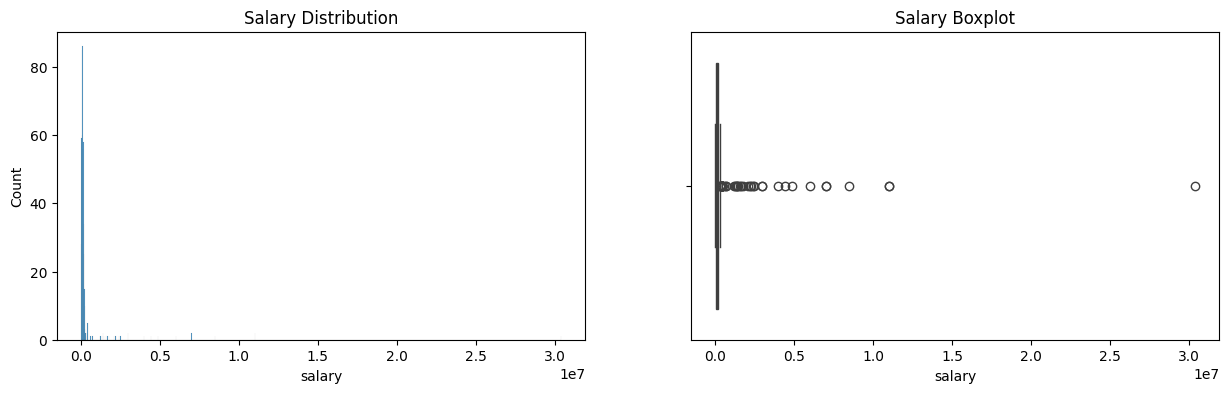

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=salaries, x='salary', ax=axes[0])
histplot.set_title('Salary Distribution')
boxplot = sns.boxplot(data=salaries, x='salary', ax=axes[1])
boxplot.set_title('Salary Boxplot')

Text(0.5, 1.0, 'Salary Boxplot')

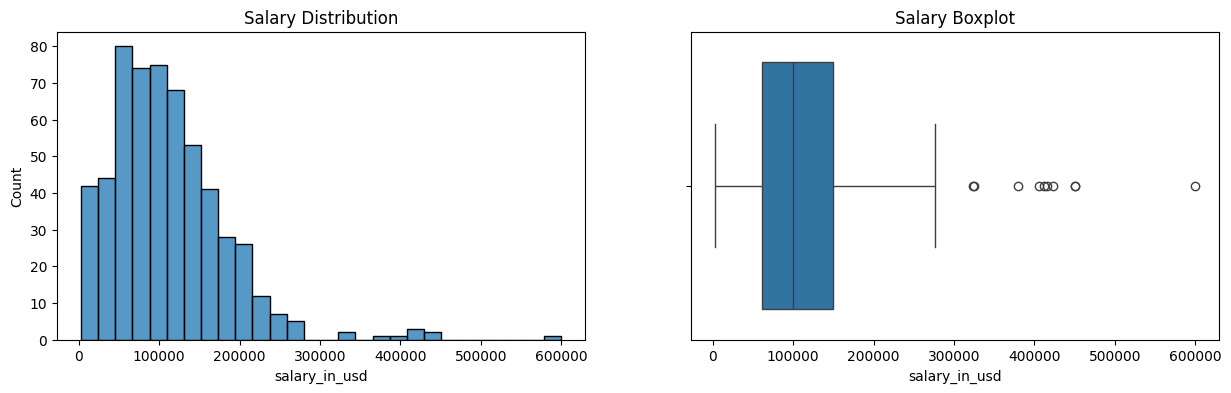

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=salaries, x='salary_in_usd', ax=axes[0])
histplot.set_title('Salary Distribution')
boxplot = sns.boxplot(data=salaries, x='salary_in_usd', ax=axes[1])
boxplot.set_title('Salary Boxplot')

по графику можно увидеть, что в признаках есть аномальные значения, лучше всего избавиться от них, чтобы в дальнейшем они не портили наши картины визуализации для анализа 

## Метод межквартильного размаха (метод Тьюки)

In [11]:
def outliers_iqr_mod(data, feature, left= 1.5, right= 1.5):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

 Алгоритм метода (метод межквартильного размаха, IQR)

- Вычислить **25-й и 75-й квантили** (первый и третий квартиль) для исследуемого признака:  
  **Q25** и **Q75**

- Вычислить **межквартильное расстояние**:  
  **IQR = Q75 − Q25**

- Вычислить **нижнюю и верхнюю границы Тьюки**:

  - Нижняя граница:  
    **bound_lower = Q25 − 1.5 × IQR**

  - Верхняя граница:  
    **bound_upper = Q75 + 1.5 × IQR**

- Найти наблюдения, выходящие за пределы интервала:  
  **[bound_lower, bound_upper]**


In [12]:
outliers, salaries = outliers_iqr_mod(data= salaries, feature= 'salary', left= 1.5, right= 1)
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {salaries.shape[0]}')

Число выбросов по методу Тьюки: 49
Результирующее число записей: 516


Text(0.5, 1.0, 'Salary Boxplot')

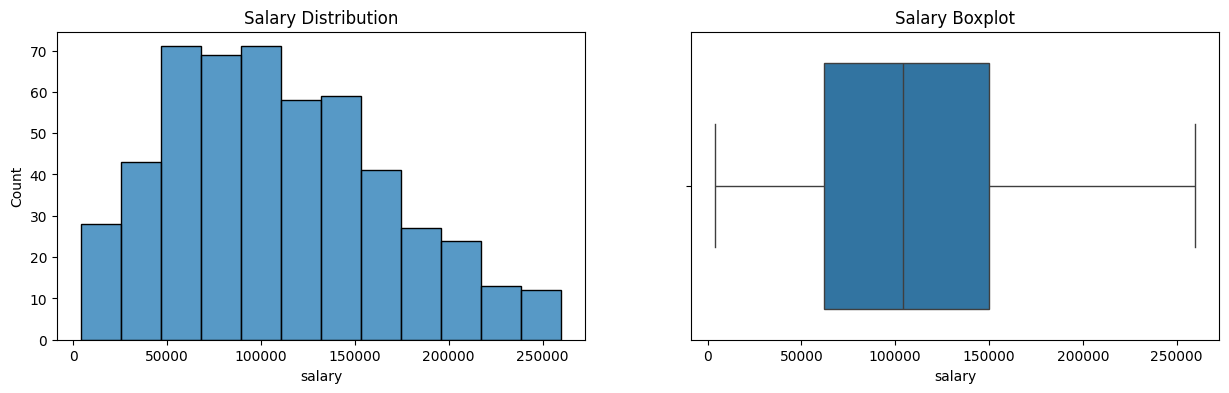

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=salaries, x='salary', ax=axes[0])
histplot.set_title('Salary Distribution')
boxplot = sns.boxplot(data=salaries, x='salary', ax=axes[1])
boxplot.set_title('Salary Boxplot')

Text(0.5, 1.0, 'Salary_in_usd Boxplot')

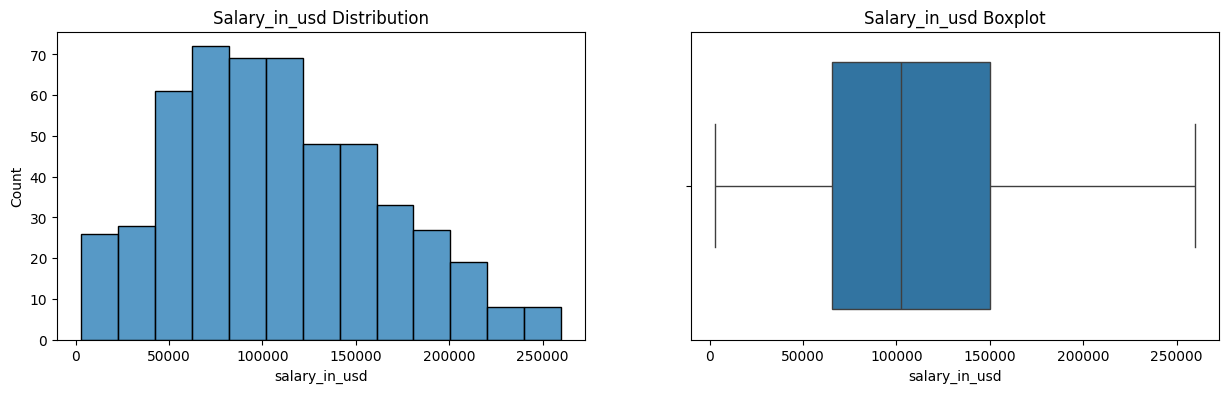

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=salaries, x='salary_in_usd', ax=axes[0])
histplot.set_title('Salary_in_usd Distribution')
boxplot = sns.boxplot(data=salaries, x='salary_in_usd', ax=axes[1])
boxplot.set_title('Salary_in_usd Boxplot')

теперь графики читаемы и понятны. По гистограмме распределение для зарплат кажется близким к нормальному, можем проверить это с помощью qq-plot.

# QQ plot

Text(0.5, 1.0, 'Квантиль-квантиль график \n для распределения зарплат')

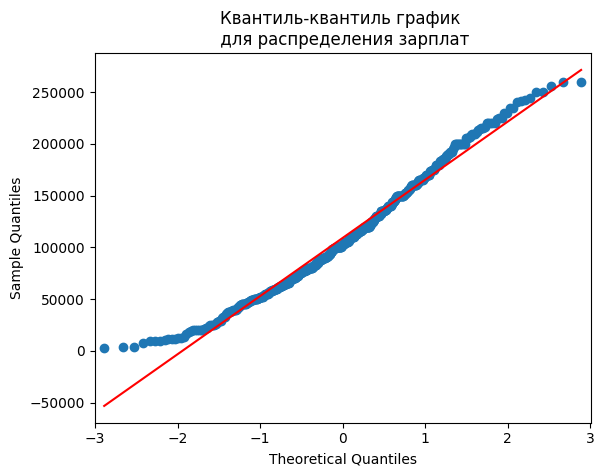

In [15]:
sm.qqplot(salaries['salary_in_usd'], line='s')
plt.title('Квантиль-квантиль график \n для распределения зарплат')

Хвосты распределения слегка отходят от нормального распределения, а так согласно графику распределение можно назвать нормальным

# Мультиколлинеарность

<Axes: >

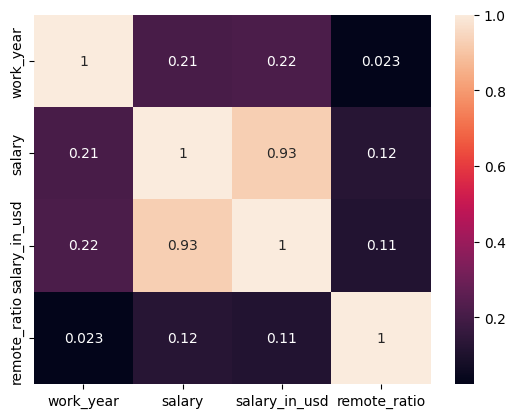

In [16]:
sns.heatmap(salaries.corr(numeric_only=True), annot=True)

По тепловой карте наблюдается мултьикоррелинеальность у признаков salary и salary_in_us. Избавимся от признака salary.

In [17]:
salaries = salaries.drop(columns= 'salary')

# Круговые диаграммы для категориальных признаков

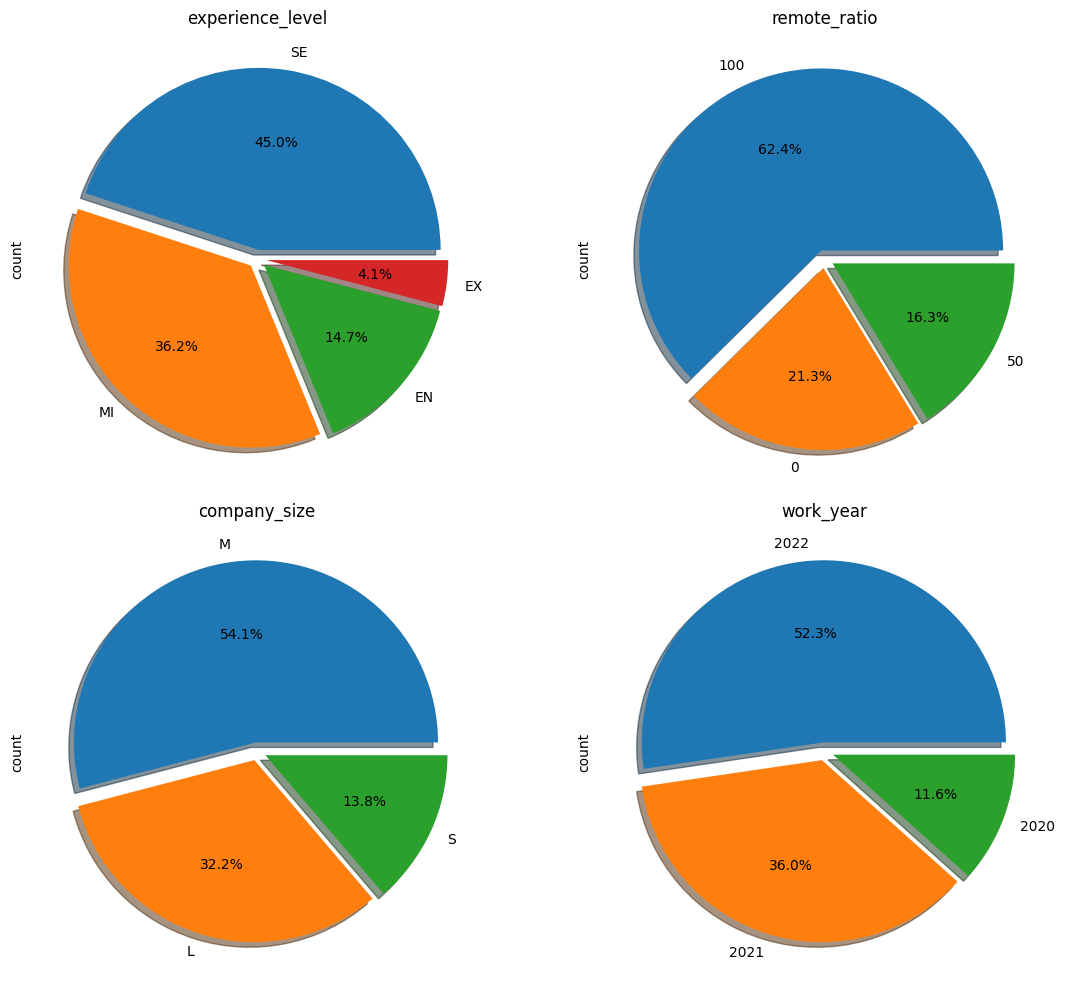

In [18]:
categorical_cols = [
    "experience_level",
    "remote_ratio",
    "company_size",
    "work_year"
]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for ax, col in zip(axes, categorical_cols):

    values = salaries[col].value_counts()
    explode = [0.05] * len(values)

    salaries[col].value_counts().plot.pie(
        ax=ax,
        autopct='%1.1f%%',
        shadow = True,
        explode = explode
    )
    ax.set_title(col)

plt.tight_layout()
plt.show()

В изучаемом датасете большинство данных с 2022 года. Большинство наблдюмаех являются сеньорами или мидами, работающих в удаленном формате.

# Карты распределения

In [19]:
com_iso3 = {
    "US":"USA", "GB":"GBR", "CA":"CAN", "DE":"DEU", "FR":"FRA", "ES":"ESP", "GR":"GRC",
    "PT":"PRT", "AT":"AUT", "NL":"NLD", "PL":"POL", "AE":"ARE", "PK":"PAK", "TR":"TUR",
    "AU":"AUS", "BR":"BRA", "JP":"JPN", "LU":"LUX", "RU":"RUS", "CZ":"CZE", "NG":"NGA",
    "DK":"DNK", "MX":"MEX", "IT":"ITA", "SI":"SVN", "BE":"BEL", "VN":"VNM", "MY":"MYS",
    "CN":"CHN", "DZ":"DZA", "EE":"EST", "MD":"MDA", "IE":"IRL", "KE":"KEN", "IN":"IND",
    "CO":"COL", "IR":"IRN", "MT":"MLT", "IL":"ISR", "UA":"UKR", "IQ":"IRQ", "RO":"ROU",
    "SG":"SGP", "HR":"HRV", "NZ":"NZL", "HN":"HND", "CH":"CHE",
}

# Корректируем под нужный формат ISO-3
country_counts = salaries["company_location"].value_counts().reset_index()
country_counts.columns = ["iso2", "count"]

country_counts["iso3"] = country_counts["iso2"].map(com_iso3)

fig = px.choropleth(
    country_counts,
    locations="iso3",
    locationmode="ISO-3",      
    color="count",
    color_continuous_scale= 'Viridis',
    title="Распределение компаний по странам",
    range_color=(0, 60),
    labels={"count": "Количество наблюдений"}
)

fig.update_layout(
    geo=dict(showframe=False, showcoastlines=True),
)

fig.show()

In [20]:
empl_iso3 = {
    "US":"USA","GB":"GBR","CA":"CAN","DE":"DEU","FR":"FRA","ES":"ESP","GR":"GRC",
    "PK":"PAK","PT":"PRT","BR":"BRA","NL":"NLD","JP":"JPN","PL":"POL","IT":"ITA",
    "RU":"RUS","IN":"IND","AE":"ARE","AT":"AUT","TR":"TUR","AU":"AUS","VN":"VNM",
    "RO":"ROU","SI":"SVN","BE":"BEL","SG":"SGP","NG":"NGA","RS":"SRB","IE":"IRL",
    "BO":"BOL","HN":"HND","EE":"EST","MY":"MYS","TN":"TUN","DZ":"DZA","AR":"ARG",
    "CZ":"CZE","JE":"JEY","LU":"LUX","PR":"PRI","NZ":"NZL","IQ":"IRQ","DK":"DNK",
    "HK":"HKG","KE":"KEN","MD":"MDA","CO":"COL","IR":"IRN","PH":"PHL","MX":"MEX",
    "MT":"MLT","UA":"UKR","HR":"HRV","BG":"BGR","CH":"CHE"
}

# Корректируем под нужный формат ISO-3
country_counts = salaries["employee_residence"].value_counts().reset_index()
country_counts.columns = ["iso2", "count"]
country_counts["iso3"] = country_counts["iso2"].map(empl_iso3)


fig = px.choropleth(
    country_counts,
    locations="iso3",
    locationmode="ISO-3",
    color="count",
    color_continuous_scale="Viridis",
    title="Распределение сотрудников по странам проживания",
    range_color=(0, 60),
    labels={"count": "Количество наблюдений"}
)

fig.update_layout(
    geo=dict(showframe=False, showcoastlines=True)
)

fig.show()

Большинство компаний и сотрудников наохдятся в США, остальные преимущественно в Европе или Канаде.

# Boxplot для анализа зарплат

## Зависимость зарплат от должностей

<Figure size 1000x600 with 0 Axes>

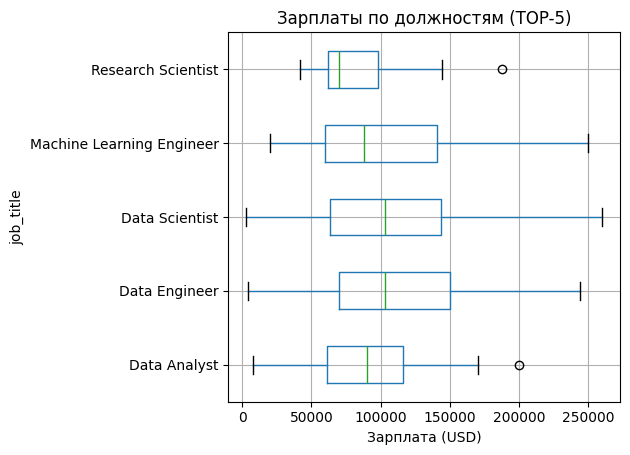

In [21]:
top_jobs = salaries["job_title"].value_counts().head(5).index
subset = salaries[salaries["job_title"].isin(top_jobs)]

plt.figure(figsize=(10, 6))
subset.boxplot(column="salary_in_usd", by="job_title", vert=False)
plt.title("Зарплаты по должностям (TOP-5)")
plt.suptitle("")
plt.xlabel("Зарплата (USD)")
plt.tight_layout()
plt.show()


Наибольшую медиану зарплат и квантили 25 и 75 имеют Data Scientist. Наименьшая медиана у Research Scientist.

## Зависимость зарплат от уровня профессианальног опыта

C:\Users\user\AppData\Local\Temp\ipykernel_7240\2636478621.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




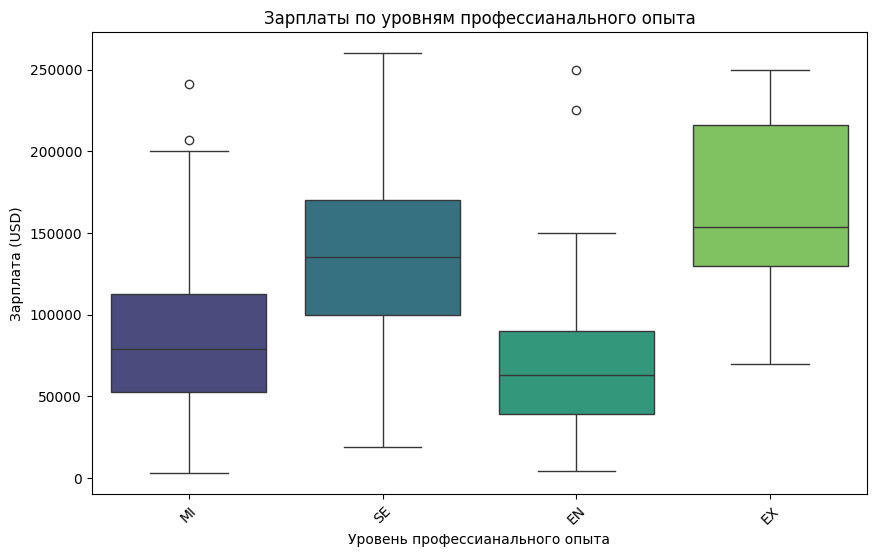

In [22]:
plt.figure(figsize=(10, 6))
boxplot = sns.boxplot(
    data=salaries,
    x='experience_level',
    y='salary_in_usd',
    palette='viridis'
)
boxplot.set_title('Зарплаты по уровням профессианального опыта')
plt.xlabel('Уровень профессианального опыта')
plt.ylabel('Зарплата (USD)')
plt.xticks(rotation=45)
plt.show()

По графикам, как ожидалось, чем выше уровень профессиального опыта, тем больше зарплаты.

## Зависимость зарплат от локации компании

C:\Users\user\AppData\Local\Temp\ipykernel_7240\1783825026.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




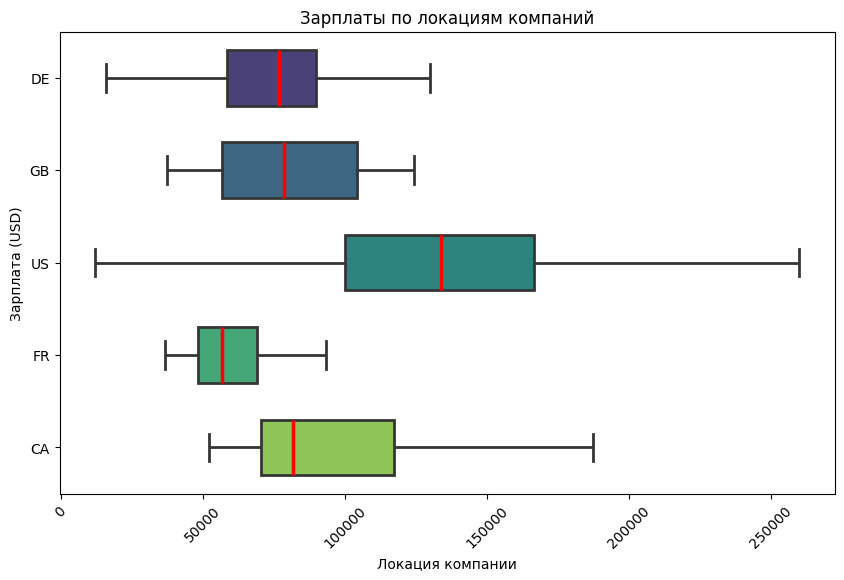

In [23]:
top_countries = salaries['company_location'].value_counts().head(5).index
subset = salaries[salaries["company_location"].isin(top_countries)]

plt.figure(figsize=(10, 6))
boxplot = sns.boxplot(
    data=subset,
    y='company_location',         
    x='salary_in_usd',
    palette='viridis',
    width=0.6,
    showfliers=False, # убираем выбросы 
    linewidth=2,
    medianprops=dict(color="red", linewidth=2.5)
)

boxplot.set_title('Зарплаты по локациям компаний')
plt.xlabel('Локация компании')
plt.ylabel('Зарплата (USD)')
plt.xticks(rotation=45)
plt.show()

Среди 5 наиболее популярных наблдюдаемых локаций компаний, наилучшие зарплаты в США, а худшие во Франции.

## Зависимость зарплат от размеров компании

C:\Users\user\AppData\Local\Temp\ipykernel_7240\3553520677.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




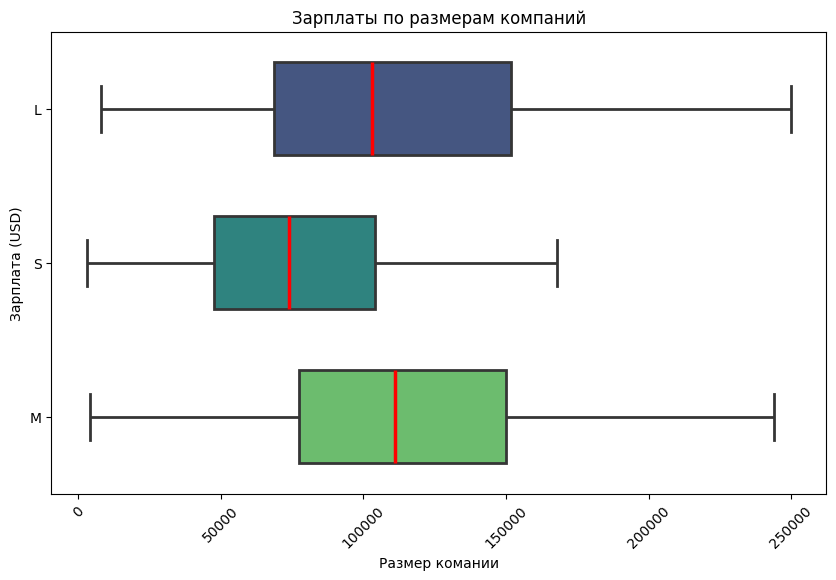

In [24]:
plt.figure(figsize=(10, 6))
boxplot = sns.boxplot(
    data=salaries,
    y='company_size',         
    x='salary_in_usd',
    palette='viridis',
    width=0.6,
    showfliers=False, # убираем выбросы 
    linewidth=2,
    medianprops=dict(color="red", linewidth=2.5)
)

boxplot.set_title('Зарплаты по размерам компаний')
plt.xlabel('Размер комании')
plt.ylabel('Зарплата (USD)')
plt.xticks(rotation=45)
plt.show()

Средние и крупные компании (от 50 сотрудников) предлагают примерно одинаковые зарплаты и больше, чем мелкие компании.

# Линейный грфик зависимости зарплат Data Scientist по годам

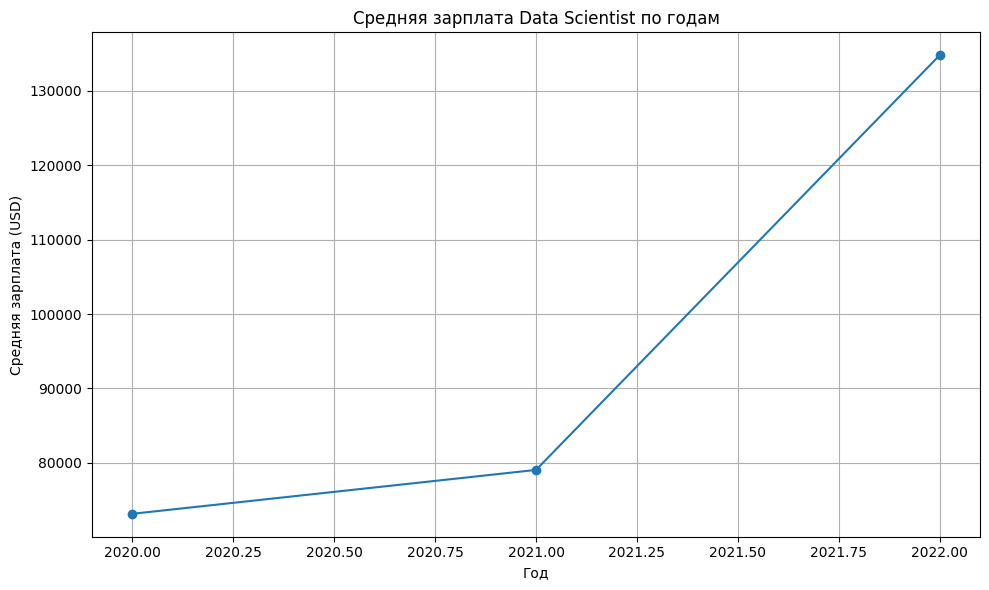

In [25]:
ds = salaries[salaries["job_title"] == "Data Scientist"]

# Агрегация: средняя зарплата по годам
salary_by_year = (ds.groupby("work_year")["salary_in_usd"].mean().reset_index())

plt.figure(figsize=(10, 6))
plt.plot(
    salary_by_year["work_year"],
    salary_by_year["salary_in_usd"],
    marker="o"
)

plt.title("Средняя зарплата Data Scientist по годам")
plt.xlabel("Год")
plt.ylabel("Средняя зарплата (USD)")
plt.grid(True)
plt.tight_layout()
plt.show()

Можно заметить значительный скачок вверх у средней зарплаты Data Scientist в 2022 году по сравнению с предыдущим. Это может свидельствовать о развитии индустрии и увеличении спроса на данных специалистов.

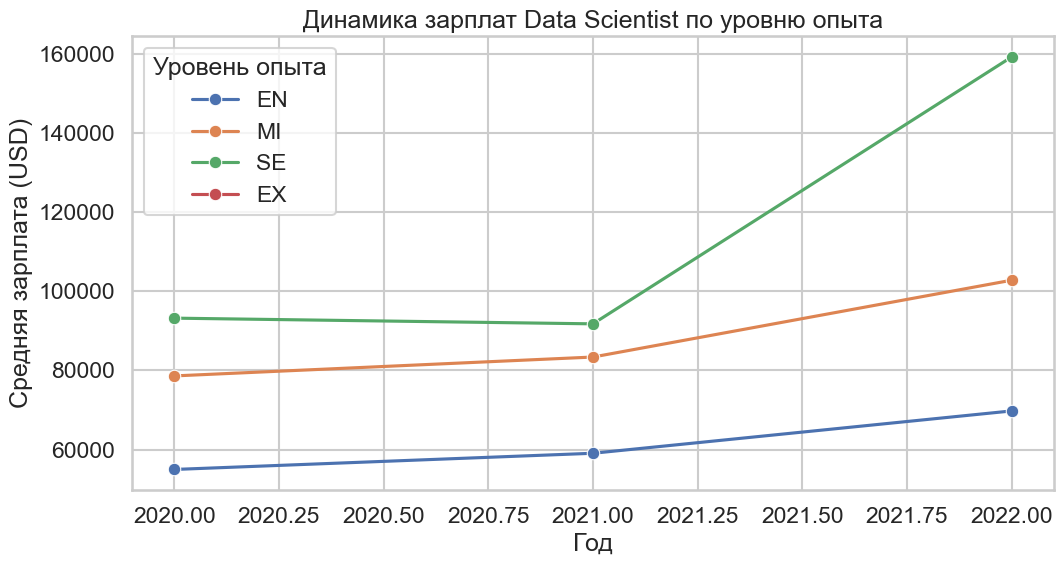

In [26]:
ds = salaries[salaries["job_title"] == "Data Scientist"]

# Агрегация по году и уровню опыта
agg = (ds.groupby(["work_year", "experience_level"])["salary_in_usd"].mean().reset_index())

order = ["EN", "MI", "SE", "EX"]

sns.set_theme(style="whitegrid", context="talk")

plt.figure(figsize=(11, 6))

sns.lineplot(
    data=agg,
    x="work_year",
    y="salary_in_usd",
    hue="experience_level",
    hue_order=order,
    marker="o"
)

plt.title("Динамика зарплат Data Scientist по уровню опыта")
plt.xlabel("Год")
plt.ylabel("Средняя зарплата (USD)")
plt.legend(title="Уровень опыта")
plt.tight_layout()
plt.show()

Посмотрев динамику по уровням опыта, можно увидеть, что значительный рост в зарплатах наблюдается именно у Senior.

# PCA (3 компоненты)

In [27]:
from sklearn.preprocessing import StandardScaler
df_red = salaries.copy()

# Категориальные признаки кодируем числами
cat_cols = [
    "experience_level",
    "job_title",
    "employee_residence",
    "company_location",
    "company_size"
]

df_red = pd.get_dummies(df_red, columns=cat_cols, drop_first=True)

# Числовые признаки
num_cols = ["salary_in_usd", "remote_ratio", "work_year"]

X = df_red[num_cols + [c for c in df_red.columns if c not in salaries.columns]]

# Масштабирование
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [28]:
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2", "PC3"])
pca_df["experience_level"] = salaries["experience_level"].values

explained_var = 100 * pca.explained_variance_ratio_[:3].sum()

fig = px.scatter_3d(
    pca_df,
    x="PC1",
    y="PC2",
    z="PC3",
    color="experience_level",
    opacity=0.75,
    title=f"PCA (3 компоненты) — доля объяснённой дисперсии: {explained_var:.2f}%",
    hover_data=["experience_level"]
)

fig.update_traces(marker=dict(size=5))
fig.update_layout(
    scene=dict(
        xaxis_title="PC1",
        yaxis_title="PC2",
        zaxis_title="PC3"
    ),
    legend_title_text="уровень профессианального опыта"
)

fig.show()


In [29]:
# избавимся от выброса для лучшего масштабирования
Q1 = pca_df["PC2"].quantile(0.25)
Q3 = pca_df["PC2"].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

pca_df = pca_df[(pca_df["PC2"] >= lower) & (pca_df["PC2"] <= upper)].copy()

explained_var = 100 * pca.explained_variance_ratio_[:3].sum()

fig = px.scatter_3d(
    pca_df,
    x="PC1",
    y="PC2",
    z="PC3",
    color="experience_level",
    opacity=0.75,
    title=f"PCA (3 компоненты) — доля объяснённой дисперсии: {explained_var:.2f}%",
    hover_data=["experience_level"]
)

fig.update_traces(marker=dict(size=5))
fig.update_layout(
    scene=dict(xaxis_title="PC1", yaxis_title="PC2", zaxis_title="PC3"),
    legend_title_text="уровень профессианального опыта"
)

fig.show()

Линейное разделение с помощью PCA выглядит неудачным, это видно и по графику и по доле объясненной дисперсии. Это связанно с данными в датасете, а не с самим методом. В нашем датасете в основном только категориальные признаки и не особо информативные чиловые признаки (remote_ratio, work_year).

# Umap

In [ ]:
reducer = umap.UMAP(
    n_components=3,
    n_neighbors=30,     
    min_dist=0.1,
    metric="euclidean",
    random_state=42
)

X_umap = reducer.fit_transform(X_scaled)

umap_df = pd.DataFrame(X_umap, columns=["U1", "U2", "U3"])
umap_df["experience_level"] = salaries["experience_level"].values

fig = px.scatter_3d(
    umap_df,
    x="U1",
    y="U2",
    z="U3",
    color="experience_level",
    opacity=0.75,
    title="UMAP (3D): проекция данных (color = experience_level)",
    hover_data=["experience_level"]
)

fig.update_traces(marker=dict(size=4))
fig.update_layout(
    scene=dict(
        xaxis_title="UMAP-1",
        yaxis_title="UMAP-2",
        zaxis_title="UMAP-3"
    ),
    legend_title_text="experience_level"
)

fig.show()

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [ ]:
umap_clean = umap_df.copy()

# Посмотрим на огрниченном масштабе ([1.5 * 25% квантиль, 1.5* 75% квантиль])
for col in ["U1", "U2", "U3"]:
    Q1 = umap_clean[col].quantile(0.25)
    Q3 = umap_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    umap_clean = umap_clean[(umap_clean[col] >= lower) & (umap_clean[col] <= upper)]

fig = px.scatter_3d(
    umap_clean,
    x="U1", y="U2", z="U3",
    color="experience_level",
    opacity=0.75,
    title="UMAP (3D) без выбросов (IQR по U1/U2/U3)"
)
fig.update_traces(marker=dict(size=4))
fig.show()

Нелинейное разделение выглядит уже получше линейного, можно рассмотреть класстеры по уровням профессианального опыта, однако опять же далеко от идеала (класстеры смешиваются с дург другом). Это все так же связанно с не самым подходящим датасетом и данными для таких разделений.

# Вывод

В ходе выполнения работы был проведён анализ данных, посвящённый исследованию заработных плат специалистов в области Data Science. Было установлено, что многие факторы влияют на урвень зарплат. Уровень профессионального опыта оказывает существенное влияние на медианные значения заработной платы. Компании расположенные в США готовы в среднем платить своим сотрудникам больше.
В рамках работы были выявлены и проанализированы выбросы как в исходных числовых признаках, так и в пространстве пониженной размерности. Удаление единичных аномальных наблюдений позволило повысить информативность визуализаций. Для исследования возможной кластеризации были применены методы снижения размерности. Линейный метод главных компонент (PCA) показал отсутствие чёткой линейной кластеризации и низкую долю объяснённой дисперсии первых компонент. В то же время применение нелинейных методов (UMAP) позволило выявить локальные группы наблюдений и частичную кластеризацию, в том числе связанную с уровнем профессионального опыта, что подтверждает наличие нелинейных зависимостей между признаками.

В целом, поставленные в работе цели были достигнуты. Применение разнообразных типов визуализаций, продвинутых методов настройки графиков и методов снижения размерности позволило провести глубокий и всесторонний анализ данных, а также продемонстрировать практическую ценность визуальной аналитики при исследовании сложных многомерных наборов данных.